In [1]:
#Import Required Libraries
import pandas as pd
import datetime
import matplotlib.pylab as plt
import numpy as np
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error


In [2]:
#Import Revenue dataset
yearlysales = pd.read_csv('teleco_time_series .csv')

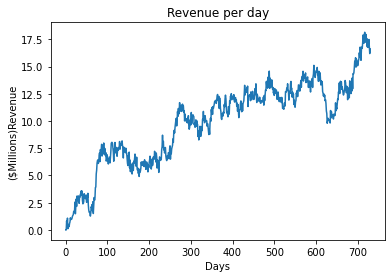

In [3]:
# Provide a line graph visualizing the realization of the time series 

plt.plot(yearlysales["Revenue"])
plt.xlabel("Days")
plt.ylabel("($Millions)Revenue")
plt.title("Revenue per day")
plt.show()

In [4]:
#Dickey Fuller Test
results = adfuller(yearlysales['Revenue'])
results

(-1.9246121573101842,
 0.3205728150793961,
 1,
 729,
 {'1%': -3.4393520240470554,
  '5%': -2.8655128165959236,
  '10%': -2.5688855736949163},
 965.0609576707513)

In [6]:
#Make stationary via differencing
yearlysales_stationary = yearlysales.diff().dropna()

In [7]:
#Dickey Fuller Test to determine if the data is now stationary
results2 = adfuller(yearlysales_stationary['Revenue'])
results2

(-44.874527193876,
 0.0,
 0,
 729,
 {'1%': -3.4393520240470554,
  '5%': -2.8655128165959236,
  '10%': -2.5688855736949163},
 965.5032159185916)

In [8]:
#Replace first row Revenue diff value as 0
yearlysales_stationary.loc[:0,'Revenue'] = 0

In [9]:
#Drop Day column and set index 
yearlysales_stationary.drop(['Day'], axis=1, inplace=True)
yearlysales_stationary.reset_index(inplace = True)
yearlysales_stationary = yearlysales_stationary.rename(columns = {'index':'Day'})

In [10]:
#Add a 1 to each row 
yearlysales_stationary['Day'] = yearlysales_stationary['Day'] + 1

In [11]:
yearlysales_stationary

,Day,Revenue
0,2,0.000793
1,3,0.824749
2,4,-0.505210
3,5,0.762222
4,6,-0.974900
...,...,...
725,727,0.170280
726,728,0.559108
727,729,-0.687028
728,730,-0.608824


<AxesSubplot:title={'center':'Seasonality'}>

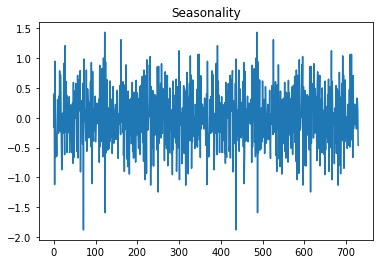

In [14]:
#Seasonality Plot - Decompose
seasonality = seasonal_decompose(yearlysales_stationary['Revenue'], model ='additive', period = 365)
plt.title('Seasonality')
seasonality.seasonal.plot()

<AxesSubplot:title={'center':'Trend'}>

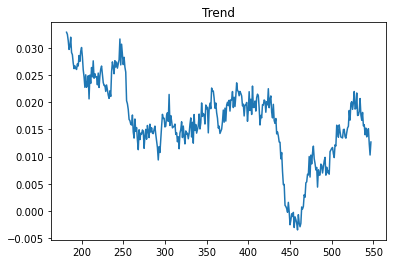

In [15]:
#Trend
plt.title('Trend')
seasonality.trend.plot()

<AxesSubplot:title={'center':'Residual'}>

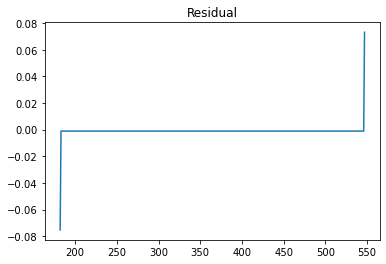

In [17]:
#Residual
plt.title('Residual')
seasonality.resid.plot()

In [18]:
#Split dataset
size = int(len(yearlysales_stationary)*.8)
sales_train = yearlysales_stationary.iloc[:size]
sales_test = yearlysales_stationary.iloc[size:]

In [19]:
#Export cleaned dataset to csv
yearlysales_stationary.to_csv('D213CleanDataset.csv')
sales_train.to_csv('D213CleanDataset-Train.csv')
sales_test.to_csv('D213CleanDataset-Test.csv')

Spectral Density

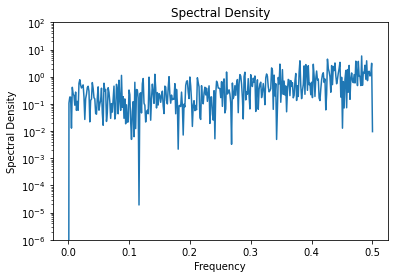

In [20]:
f,Pxx_den = signal.periodogram(yearlysales_stationary['Revenue'])
plt.semilogy(f,Pxx_den)
plt.ylim([1e-6,1e2])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

ACF

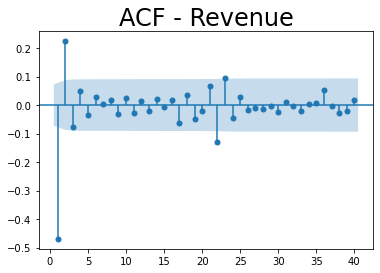

In [21]:
sgt.plot_acf(yearlysales_stationary.Revenue, lags = 40, zero = False)
plt.title("ACF - Revenue", size = 24)
plt.show()

PACF

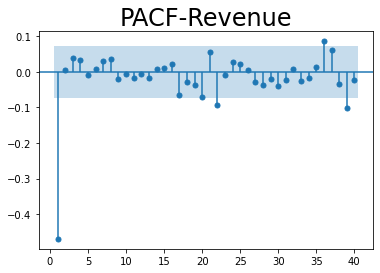

In [22]:
sgt.plot_pacf(yearlysales_stationary.Revenue, lags = 40, alpha = 0.05,  zero = False, method = ('ols'))
plt.title("PACF-Revenue", size = 24)
plt.show()

ARIMA

In [23]:
optimalmodel = auto_arima(sales_train['Revenue'], start_p = 0, start_q = 0)
optimalmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -383.946
Date:                Mon, 04 Jul 2022   AIC                            773.893
Time:                        18:01:56   BIC                            787.002
Sample:                             0   HQIC                           779.002
                                - 584                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0341      0.019      1.751      0.080      -0.004       0.072
ar.L1         -0.4597      0.036    -12.654      0.000      -0.531      -0.388
sigma2         0.2180      0.014     16.034      0.000       0.191       0.245
===================================================================================
Ljung-Box (Q):                       36.44   Jarque-Bera (JB):                 1.84
Prob(Q):                              0.63   Prob(JB):                         0.40
Heteroskedasticity (H):               0.97   Skew:                            -0.08
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
#SARIMAX
arima = SARIMAX(sales_train['Revenue'], order = (1,0,0))
arima_results = arima.fit()
diff_forecast = arima_results.get_prediction(end = 1096)
mean_forecast = diff_forecast.predicted_mean
confidence_intervals = diff_forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:,'upper Revenue']


In [25]:
#Summary
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  584
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -385.495
Date:                Mon, 04 Jul 2022   AIC                            774.990
Time:                        18:01:56   BIC                            783.730
Sample:                             0   HQIC                           778.397
                                - 584                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4568      0.036    -12.605      0.000      -0.528      -0.386
sigma2         0.2191      0.014     15.965      0.000       0.192       0.246
===================================================================================
Ljung-Box (Q):                       36.38   Jarque-Bera (JB):                 1.85
Prob(Q):                              0.63   Prob(JB):                         0.40
Heteroskedasticity (H):               0.96   Skew:                            -0.08
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
#Forecasted values
mean_forecast

0        0.000000e+00
1       -3.623479e-04
2       -3.767642e-01
3        2.307913e-01
4       -3.482005e-01
            ...      
1092   -1.166419e-174
1093    5.328470e-175
1094   -2.434168e-175
1095    1.111984e-175
1096   -5.079799e-176
Length: 1097, dtype: float64

In [27]:
mse = mean_squared_error(mean_forecast.iloc[0:730], yearlysales_stationary['Revenue'])
rmse = sqrt(mse)
mae = mean_absolute_error(mean_forecast[0:730], yearlysales_stationary['Revenue'])
print('MSE: ',mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  0.24029126664668043
RMSE:  0.4901951311943851
MAE:  0.39558634146204497


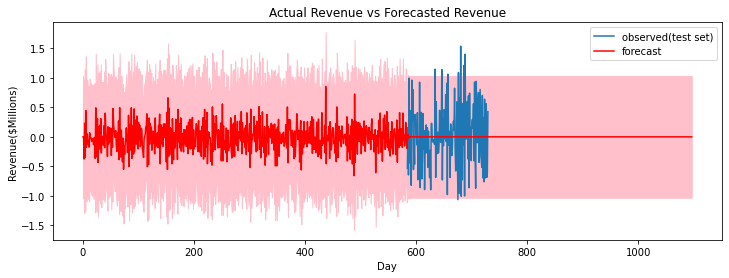

In [28]:
plt.figure(figsize = (12,4))
plt.plot(sales_test.index,sales_test['Revenue'], label = 'observed(test set)')
plt.plot(mean_forecast.index, mean_forecast, color ='r', label = 'forecast')
plt.fill_between(lower_limits.index,lower_limits,upper_limits, color = 'pink')
plt.title('Actual Revenue vs Forecasted Revenue')
plt.xlabel('Day')
plt.ylabel('Revenue($Millions)')
plt.legend()
plt.show()